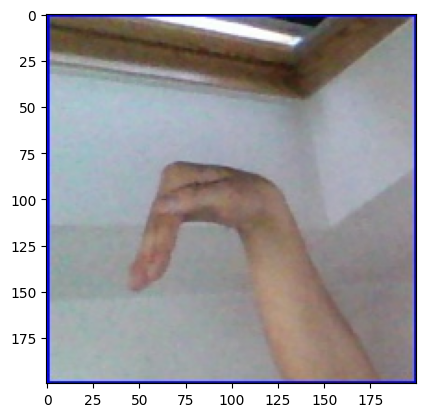

In [384]:
import cv2 as cv
from PIL import Image
import os

import matplotlib.pyplot as plt
import numpy as np

csv_path = 'data/model/keypoints_from_data.csv'
baseData = 'data/archive/asl_alphabet_train/'

sign = 'A'
first = baseData + sign + '/A1.jpg'
imgstmp = []

class SignCategory:
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __str__(self):
        return "<Label: " + self.label + "\n" + str(self.data) + ">"

categories = []
imgsAndLabels = []

for subdir, dir,files in os.walk(baseData):
    if subdir == baseData:
        continue
    
    label = subdir.replace(baseData, '')
    data = []
    
    for idx, file_name in enumerate(files):
        if idx > 250:
            continue
            
        imgPath = subdir + '/' + file_name
        img = np.asarray(Image.open(imgPath))
        data.append(img)

    imgsAndLabels.append((data, label))
    #categories.append(SignCategory(np.array(data), label))

data, label = imgsAndLabels[0]
img1 = data[0]
imgplot = plt.imshow(img1)

Something something, preprocess the thingies like from Video

In [385]:
import copy
import itertools

def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [386]:
import mediapipe as mp

use_static_image_mode = 'store_true'
min_detection_confidence = 0.7
min_tracking_confidence = 0.5

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=use_static_image_mode,
    max_num_hands=1,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)


# Mediapipe has seen your hands :eyes:
#results2d = [ hands.process(img) for img in imgs ]

results = []
for data, label in imgsAndLabels:
    for img in data:
        r = ( label, hands.process(img), img )
        results.append( r )


#results = hands.process(img)
#hand_landmarks = results.multi_hand_landmarks
#handedness = results.multi_handedness

print(len(results))
#print(hand_landmarks, "\n-------------------\n", handedness)

I0000 00:00:1707405503.925784   22032 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1707405503.927057   43142 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.2-1pop0~1704238321~22.04~36f1d0e), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)
/home/chobbie/.local/lib/python3.10/site-packages/google/protobuf/symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


7279


In [387]:
import csv

for label, mediapipe_result, raw_img in results: 
    
    if mediapipe_result.multi_hand_landmarks is not None:
        # Let's spit out the preprocessed landmarks to a CSV for training later.
        for hand_landmarks, handedness in zip(mediapipe_result.multi_hand_landmarks,
                                              mediapipe_result.multi_handedness):
            
            landmark_list = calc_landmark_list(raw_img, hand_landmarks)
            
            pre_processed_landmark_list = pre_process_landmark(landmark_list)
            with open(csv_path, 'a', newline="") as f:
                writer = csv.writer(f)
                writer.writerow([label, *pre_processed_landmark_list])



In [388]:
#Training commences

In [389]:
with open(csv_path, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

landmarks_list = []
labels_list = []
for entry in data:
    landmarks_list.append(np.array(entry[1:], dtype=np.float32))
    labels_list.append(entry[0])

landmarks_array = np.array(landmarks_list)
labels_array = np.array(labels_list)

len(labels_array) == len(landmarks_array)

True

In [390]:
from sklearn.model_selection import train_test_split

#Zip landmarks and labels, then shuffle, then unzip
zipped = list(zip(landmarks_array, labels_array))

#then shuffle
train_set, test_set = train_test_split(zipped, test_size=0.2, random_state=42)

landmarks_train = []
labels_train = []
landmarks_test = []
labels_test = []
for landmark, label in train_set:
    landmarks_train.append(landmark)
    labels_train.append(label)
for landmark, label in test_set:
    landmarks_test.append(landmark)
    labels_test.append(label)
landmarks_train = np.array(landmarks_train)
labels_train = np.array(labels_train)
landmarks_test = np.array(landmarks_test)
labels_test = np.array(labels_test)


In [391]:
labels_train_A = (labels_train == 'A')
labels_test_A = (labels_test == 'A')

In [392]:
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(landmarks_train, labels_train_A)

SGDClassifier(random_state=42)

In [393]:
idx = 55
some_lm = landmarks_array[idx]
some_lm_label = labels_array[idx]

prediction = sgd_clf.predict( [ some_lm ])
print("Label of some_lm: " + some_lm_label + "\tprediction: " + str(prediction))

Label of some_lm: del	prediction: [False]


In [394]:
##
## TIME TO LOOK AT THE STATS
##

from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, landmarks_train, labels_train_A, cv=3, scoring="accuracy")

array([0.99699022, 0.99699022, 0.99435666])

In [395]:
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import confusion_matrix

labels_train_pred = cross_val_predict(sgd_clf, landmarks_train, labels_train_A, cv=3)
cm = confusion_matrix(labels_train_A, labels_train_pred)
cm

array([[7689,   15],
       [  16,  254]])

In [396]:
## REcall+ precision
from sklearn.metrics import precision_score, recall_score 

precision = precision_score(labels_train_A, labels_train_pred) 
recall = recall_score(labels_train_A, labels_train_pred)

print(precision, recall)

0.9442379182156134 0.9407407407407408


In [397]:
##
## V OR NOT V
##
from sklearn.ensemble import RandomForestClassifier

labels_train_V = (labels_train == 'V')
labels_test_V = (labels_test == 'V')

sgd_v = SGDClassifier(random_state=42) 
sgd_v.fit(landmarks_train, labels_train_V)

forest_v = RandomForestClassifier(random_state=42)

In [398]:
##
## TIME TO LOOK AT THE STATS FOR V
##
cross_val_score(sgd_v, landmarks_train, labels_train_V, cv=3, scoring="accuracy")

labels_train_pred_v = cross_val_predict(sgd_v, landmarks_train, labels_train_V, cv=3)
cm = confusion_matrix(labels_train_V, labels_train_pred_v)
cm

array([[7629,    5],
       [  27,  313]])

In [399]:
precision_v = precision_score(labels_train_V, labels_train_pred) 
recall_v = recall_score(labels_train_V, labels_train_pred)

print(precision_v, recall_v)

0.0 0.0


In [400]:
## random forest for V
labels_probas_forest_v = cross_val_predict(forest_v, landmarks_train, labels_train_V, cv=3, method="predict_proba")

labels_probas_forest_v[:1000]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [401]:
labels_train[2]

'A'

In [402]:
##
## MULTICLASS CLASSIFICATION
##
from sklearn.svm import SVC

sgd_clf_ovo = SGDClassifier(random_state=42) 

sgd_clf.fit(landmarks_train, labels_train)

SGDClassifier(random_state=42)

In [403]:
cross_val_score(sgd_clf_ovo, landmarks_train, labels_train, cv=3, scoring="accuracy")

array([0.95109105, 0.94883371, 0.96613995])

In [404]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
landmarks_train_scaled = scaler.fit_transform(landmarks_train.astype("float64")) 
cross_val_score(sgd_clf_ovo, landmarks_train_scaled, labels_train, cv=3, scoring="accuracy")

array([0.9586155 , 0.96576373, 0.96388262])

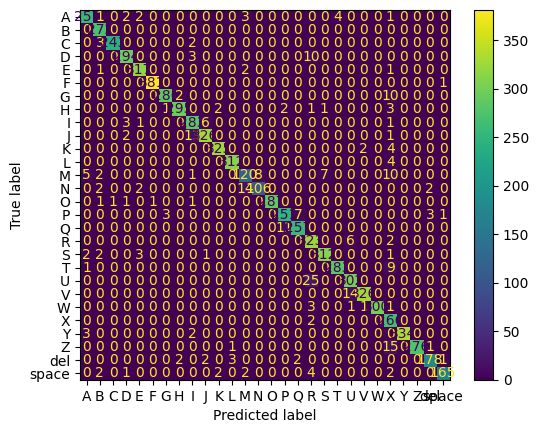

In [405]:
labels_train_predict_ovo = cross_val_predict(sgd_clf_ovo, landmarks_train_scaled, labels_train, cv=3)
ConfusionMatrixDisplay.from_predictions(labels_train, labels_train_predict_ovo)
plt.show()